# Задание 1. 
### Условие:

Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов. Для этого мы применяем метод A/B–тестирования. В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика. В качестве задания Вам необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.

### 1.2 Входные данные

В качестве входных данных Вы имеете 4 csv-файла:

groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа)   

groups_add.csv - дополнительный файл с пользователями, который вам `прислали спустя 2 дня` после передачи данных   

active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента.    

checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 


In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import pandahouse as ph
from scipy import stats
from pingouin import qqplot
from tqdm.auto import tqdm
from scipy.stats import norm

from urllib.parse import urlencode
import requests
import urllib.request





In [2]:
path1 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-gamesrodriges/fin_project_data/groups.csv'
path2 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-gamesrodriges/fin_project_data/group_add.csv'
path3 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-gamesrodriges/fin_project_data/active_studs.csv'
path4 = '/mnt/HC_Volume_18315164/home-jupyter/jupyter-e-gamesrodriges/fin_project_data/checks.csv'


In [3]:
groups_df       = pd.read_csv(path1, sep=';')
groups_add_df   = pd.read_csv(path2)
active_studs_df = pd.read_csv(path3)
checks_df       = pd.read_csv(path4, sep=';')

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.3.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


Проверим все таблицы на наличие пропусков и дубликатов:

In [4]:
l = [groups_df, groups_add_df, active_studs_df, checks_df]
names = ['groups_df', 'groups_add_df', 'active_studs_df', 'checks_df']

for n, i in enumerate(l):
    print(f"{n+1}.{names[n]}\n{i.shape}")
    print(f"Дубликаты: {len(i) > len(i.drop_duplicates())}\n")
    print(f"Пропуски:\n{i.isna().sum()}\n")
    print(f"Типы данных:\n{i.dtypes}.\n------------------")

    


1.groups_df
(74484, 2)
Дубликаты: False

Пропуски:
id     0
grp    0
dtype: int64

Типы данных:
id      int64
grp    object
dtype: object.
------------------
2.groups_add_df
(92, 2)
Дубликаты: False

Пропуски:
id     0
grp    0
dtype: int64

Типы данных:
id      int64
grp    object
dtype: object.
------------------
3.active_studs_df
(8341, 1)
Дубликаты: False

Пропуски:
student_id    0
dtype: int64

Типы данных:
student_id    int64
dtype: object.
------------------
4.checks_df
(541, 2)
Дубликаты: False

Пропуски:
student_id    0
rev           0
dtype: int64

Типы данных:
student_id      int64
rev           float64
dtype: object.
------------------


Посмотрим на количество уникальных пользователей и на размеры групп:


In [5]:
groups_df.head(1)

,id,grp
0,1489,B


In [6]:
print(groups_df.id.nunique())
print(groups_df.grp.value_counts())

74484
B    59813
A    14671
Name: grp, dtype: int64


In [7]:
# посмотрим на процент пользователей в контрольной группе
14671/74484 * 100

19.69684764513184

**_Мы видим довольно большую разницу в количестве пользователей в группах - соотношение около 20/80, причем 20% пользователей в контрольной группе, что очень странно. Обычно мы хотим или равные группы в АБ тесте, или же если мы хотим протестировать изменения с меньшим риском, мы делаем тестовую группу меньше. Здесь же количество пользователей в тестовой группе является большинством. На этом этапе я бы спросил чем вызвано такое разделение на группы._**

Объединим наш основной датафрейм с дополнительным файлом, который прислали спустя 2 дня:

In [8]:
frames = [groups_df, groups_add_df]

all_users_df = pd.concat(frames, ignore_index=True)
all_users_df.shape

(74576, 2)

Переименуем колонки, чтобы объединить таблицу активных студентов с таблицей всех пользователей, и объединим:

In [9]:
active_studs_df = active_studs_df.rename(columns={'student_id': 'id'})

active_groups = active_studs_df.merge(all_users_df, on='id', how='left')

print(active_groups.shape)
active_groups.head(1)


(8341, 2)


,id,grp
0,581585,A


То же самое проделаем для таблицы с оплатой:

In [10]:
checks_df = checks_df.rename(columns={'student_id': 'id'})

# сразу же заполним нулями там, где нет оплаты
full_df = active_groups.merge(checks_df, on='id', how='left').fillna(0)

full_df.head(1)

,id,grp,rev
0,581585,A,0.0


Посмотрим на количество людей в каждой группе:

In [11]:
full_df.grp.value_counts()

B    6803
A    1538
Name: grp, dtype: int64

In [12]:
1538 / (1538 + 6803)

0.18439036086800145

`Среди активных пользователей примерно такое же отношение количества людей в контрольной и тестовой группах как и среди всех пользователей.`

Посмотрим на количество платящих пользователей в каждой группе:

In [13]:
full_df.query('rev > 0') \
    .groupby('grp') \
    .id.count()

grp
A     78
B    314
Name: id, dtype: int64

## !!!

**_На данном этапе стоит отметить, что общее количество платящих пользователей которые зашли на платформу во время проведения эксперимента - 392 человека, однако в таблице с оплатой `checks_df` у нас 541 уникальных пользователей, которые совершили оплату. Это значит, что каким-то образом 149 пользователей совершили оплату при этом не заходя на платформу во время эксперимента. Эту ошибку тоже стоит уточнить._**


In [14]:
checks_df.nunique()

id     541
rev     39
dtype: int64

In [15]:
541-392

149

### Метрики для анализа.

В данном случае нам важна метрика CR - конверсия в покупку, а так же ARPPU и ARPU - средняя выручка с каждого платящего пользователя и средняя выручка со всех пользователей участвовавших в эксперименте. Проанализировав эти метрики мы сможем понять, внедрять новую систему оплаты или нет. 

Соберем все метрики для удобства в одну таблицу:

In [16]:
# переименуем названия групп из "A" & "B" в "Control" & "Test", чтобы потом было удобнее визуализировать
full_df['grp'] = full_df['grp'].apply(lambda x: 'Control' if x == 'A' else 'Test')

# добавляем колонку оплатил/не оплатил
full_df['category'] = full_df['rev'].apply(lambda x: 1 if x > 0 else 0)

# создаем финальный датафрейм со всеми метриками
final_metrics_df = full_df.groupby('grp', as_index=False) \
    .agg({'id': 'count',
          'category': 'sum',
          'rev': 'sum'}) \
    .rename(columns={'grp': 'group',
                     'id': 'total_users',
                     'category': 'paying_users',
                     'rev': 'revenue'})

final_metrics_df['CR'] = final_metrics_df.paying_users / final_metrics_df.total_users * 100
final_metrics_df['ARPU'] = final_metrics_df.revenue / final_metrics_df.total_users
final_metrics_df['ARPPU'] = final_metrics_df.revenue / final_metrics_df.paying_users


final_metrics_df

,group,total_users,paying_users,revenue,CR,ARPU,ARPPU
0,Control,1538,78,72820.0000,5.071521,47.347204,933.589744
1,Test,6803,314,394974.0035,4.615611,58.058798,1257.878992


In [17]:
print(-round(1 - final_metrics_df.query("group == 'Test'")['CR'][1] / #CR difference
          final_metrics_df.query("group == 'Control'")['CR'][0],3))
print(-round(1 - final_metrics_df.query("group == 'Test'")['ARPU'][1] / #ARPU difference
          final_metrics_df.query("group == 'Control'")['ARPU'][0],3)) 
print(-round(1 - final_metrics_df.query("group == 'Test'")['ARPPU'][1] / #ARPPU difference
          final_metrics_df.query("group == 'Control'")['ARPPU'][0],3))

-0.09
0.226
0.347


#### Здесь интересно подметить то, что CR в тестовой группе понизился по сравнению с контрольной на 9 процентов, но при этом ARPU и ARPPU довольно значительно выросли. Позже мы проверим статзначимость этих результатов.  Посмотрим на распределение выручки в обеих группах по процентилям:

In [18]:
full_df.query('grp == "Control" & rev > 0').rev.describe()

count      78.000000
mean      933.589744
std       919.932711
min       199.000000
25%       290.000000
50%       585.000000
75%      1114.750000
max      3660.000000
Name: rev, dtype: float64

In [19]:
full_df.query('grp == "Test" & rev > 0').rev.describe()

count     314.000000
mean     1257.878992
std       790.864254
min       199.000000
25%       511.750000
50%      1140.000000
75%      1900.000000
max      4650.000000
Name: rev, dtype: float64

#### Как мы видим, в контрольной группе только 25% пользователи совершали покупки больше чем на 1114 рублей, в то время как в тестовой группе 50% совершали покупки больше чем на 1140 рублей. То есть хоть и CR в контрольной группе был больше, в тестовой группе больше пользователей совершали более дорогие покупки.

Визуализируем наши метрики:

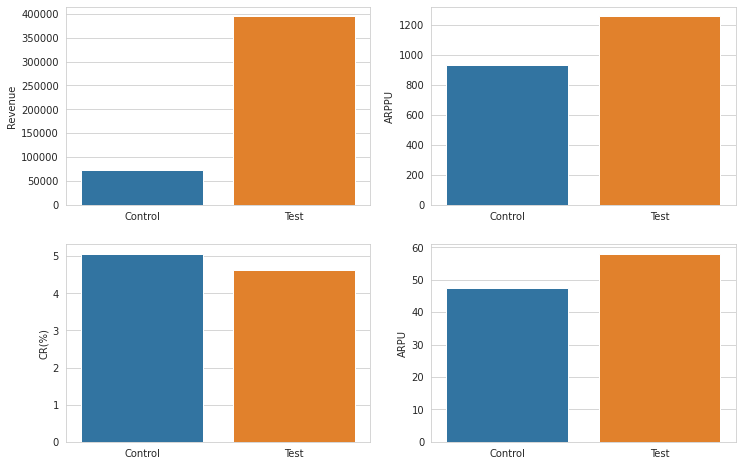

In [20]:
sns.set_style("whitegrid")

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

sns.barplot(data=final_metrics_df, x = 'group', y = 'revenue', ax=ax1)
sns.barplot(data=final_metrics_df, x = 'group', y = 'ARPPU',   ax=ax2)
sns.barplot(data=final_metrics_df, x = 'group', y = 'CR',      ax=ax3)
sns.barplot(data=final_metrics_df, x = 'group', y = 'ARPU',    ax=ax4)

ax1.set_ylabel('Revenue')
ax3.set_ylabel('CR(%)')

ax1.set_xlabel('')
ax2.set_xlabel('')
ax3.set_xlabel('')
ax4.set_xlabel('')

plt.show()

### 1. Анализ CR 
Посмотрим на конверсию в покупку в обеих группах:

In [21]:
conversion_control = full_df.query('grp == "Control" & rev > 0').id.count() / full_df.query('grp == "Control"').id.count()
conversion_test    = full_df.query('grp == "Test" & rev > 0').id.count() / full_df.query('grp == "Test"').id.count()

print(f'Control: {round(conversion_control*100, 2)}%')
print(f'Test: {round(conversion_test*100,2)}%')

Control: 5.07%
Test: 4.62%


Как видим, незначительная разница в конверсии есть. Но теперь используем тест хи-квадрат, чтобы проверить статзначимы ли эти различия. 

`H0 = нет различий в CR между двумя группами.`

In [22]:
full_df.tail()

,id,grp,rev,category
8336,1794344,Test,0.0,0
8337,296883,Test,0.0,0
8338,3598448,Test,0.0,0
8339,3610547,Test,290.0,1
8340,205705,Test,0.0,0


In [23]:
# Используем кросстаб, чтобы создать таблицу сопряженности
contingency = pd.crosstab(full_df['grp'],full_df['category'])
contingency

category,0,1
grp,,
Control,1460,78
Test,6489,314


In [24]:
res = stats.chi2_contingency(contingency)
print(f'Статистика = {res[0]}')
print(f'p-value = {res[1]}')

Статистика = 0.48480826522557896
p-value = 0.48625240457231045


##### Вывод: как мы видим, p-value > 0.05, поэтому мы не можем отвергнуть H0. Значимых различий в Conversion Rate между тестовой и контрольной группами нет. 

### 2. Анализ ARPPU
Теперь посмотрим на среднюю выручку в каждой группе среди платящих пользователей:

In [25]:
control_ARPPU = full_df.query('grp == "Control" & rev > 0').rev
test_ARPPU = full_df.query('grp == "Test" & rev > 0').rev

print(round(control_ARPPU.mean(), 2))
print(round(test_ARPPU.mean(), 2))

933.59
1257.88


In [26]:
print(round((test_ARPPU.mean() / control_ARPPU.mean() - 1)  * 100,2),'%')

34.74 %


**_Мы видим довольно значительную разницу в ARPPU между двумя группами. В тестовой группе выручка выросла почти на 35%._**

Теперь давайте проверим статистически ли значимый этот результат.

Проверим данные на нормальность (H0 = данные распределены нормально):

In [27]:
print(stats.normaltest(control_ARPPU))
print(stats.normaltest(test_ARPPU))

NormaltestResult(statistic=30.378419638487458, pvalue=2.531686880422046e-07)
NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)


`p-value < 0.05, отклоняем нулевую гипотезу, данные распределены не нормально.`

Посмотрим на распределение на графике:

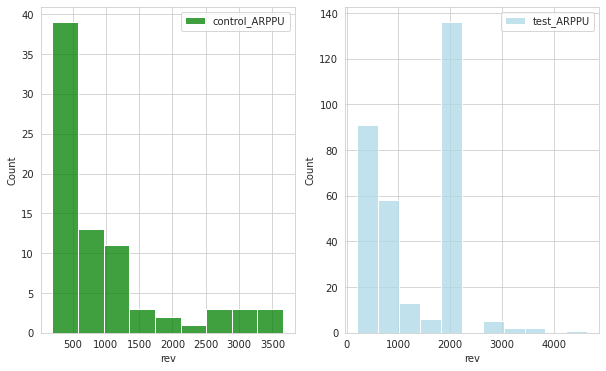

In [28]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1 = sns.histplot(control_ARPPU, ax=ax1, label = 'control_ARPPU', color='green')
ax2 = sns.histplot(test_ARPPU, ax=ax2, label = 'test_ARPPU', color='lightblue')
ax1.legend()
ax2.legend()
plt.show()

А так же посмотрим на qqplot:

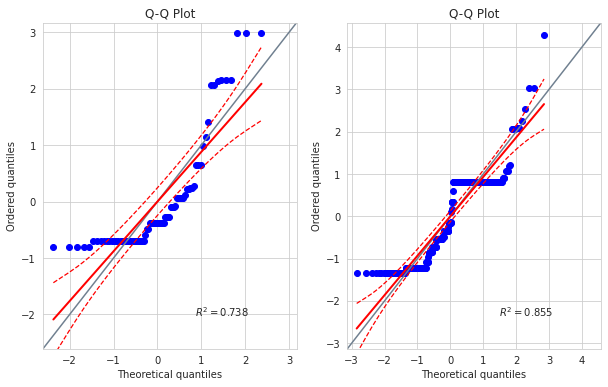

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 6))
ax1 = qqplot(control_ARPPU, dist='norm', ax=ax1)
ax2 = qqplot(test_ARPPU, dist='norm', ax=ax2)

Проверим являются ли дисперсии внутри групп примерно одинаковыми (гомогенными) с помощью теста Левена. Т.к. данные распределены не нормально, будем использовать параметр "median".

In [30]:
print(stats.levene(control_ARPPU, test_ARPPU, center='median'))

LeveneResult(statistic=3.0756816999816055, pvalue=0.08025675761347022)


p-value > 0.05, НЕ отклоняем нулевую гипотезу (дисперсии являются гомогенными).

Построим графики boxplot, чтобы посмотреть если ли в данных выбросы:

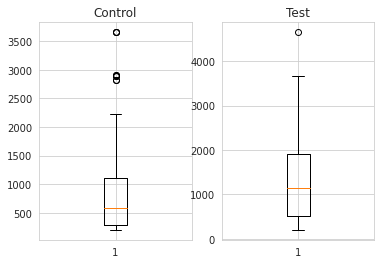

In [31]:
figure, (ax1, ax2) = plt.subplots(1,2)
ax1.boxplot(x = control_ARPPU);
ax1.set_title('Control');
ax2.boxplot(x = test_ARPPU);
ax2.set_title('Test');

**Для проверки статзначимости используем метод bootstrap. Мы сравниваем среднюю выручку, поэтому будем использовать статистику `mean`**

H0 = нет различий в ARPPU между тестовой и контрольной группой.

In [32]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_num = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_num)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {#"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

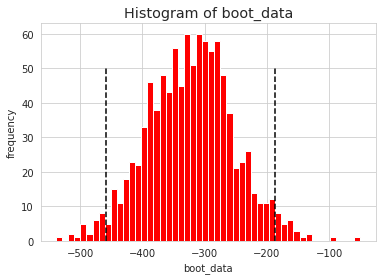

{'quants':                 0
 0.025 -457.519358
 0.975 -186.299216,
 'p_value': 2.5841483571984284e-06}

In [33]:
get_bootstrap(control_ARPPU, test_ARPPU)

`0 не входит в доверительный интервал, а p-value значительно меньше 0.05, а значит мы отклоняем нулевую гипотезу. Разница в ARPPU между тестовой и контрольной группами есть.`

### 3. Анализ ARPU

Посмотрим на среднюю выручку с каждого пользователя.

In [34]:
control_ARPU = full_df.query('grp == "Control"').rev
test_ARPU = full_df.query('grp == "Test"').rev

print(round(control_ARPU.mean(), 2))
print(round(test_ARPU.mean(), 2))

47.35
58.06


In [35]:
print(round((test_ARPU.mean() / control_ARPU.mean() - 1) * 100,2),'%')

22.62 %


ARPU в тестовой группе увеличилось примерно на 22.6%. Проверим статзначимость этого результата.

Проверим нормальность и гомогенность данных.

In [36]:
print(stats.normaltest(control_ARPU))
print(stats.normaltest(test_ARPU))
print('p-value < 0.05. Распределение не нормально.\n')
print(stats.levene(control_ARPU, test_ARPU, center='median'))
print('p-value > 0.05. Дисперсии гомогенны.\n')


NormaltestResult(statistic=2240.5957974074026, pvalue=0.0)
NormaltestResult(statistic=7797.399211581946, pvalue=0.0)
p-value < 0.05. Распределение не нормально.

LeveneResult(statistic=1.5014608294336371, pvalue=0.22048133327049665)
p-value > 0.05. Дисперсии гомогенны.



Посмотрим на выбросы:

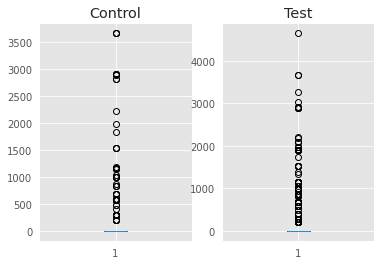

In [37]:
figure, (ax1, ax2) = plt.subplots(1,2)
ax1.boxplot(x = control_ARPU);
ax1.set_title('Control');
ax2.boxplot(x = test_ARPU);
ax2.set_title('Test');

Мы видим, что большинство значений в наших выборках равно 0, т.к. большинство пользователей неплатящие.

**Так же применим метод bootstrap. Здесь мы тоже используем в качестве статистики среднее.**

H0 = нет различий в ARPU среди всех пользователей между тестовой и контрольной группой.

In [38]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_num = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_num)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, # чтобы сохранить дисперсию, берем такой же размер выборки
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) 
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if abs(bar.get_x()) <= quants.iloc[0][0] or abs(bar.get_x()) >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {#"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

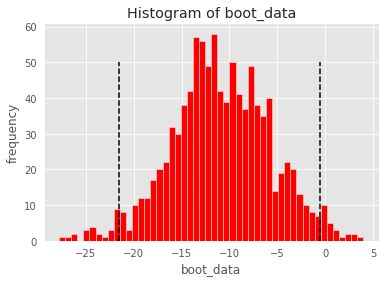

{'quants':                0
 0.025 -21.546851
 0.975  -0.540431,
 'p_value': 0.0335166825349054}

In [39]:
get_bootstrap(control_ARPU, test_ARPU)

`Здесь мы тоже видим, что 0 не входит в доверительный интервал, а p-value меньше 0.05, соответственно мы отклоняем H0. Различия в ARPU среди всех пользователей между тестовой и контрольной группой есть.`

### ВЫВОД:

**По результатам анализа метрик CR, ARPPU и ARPU после проведения АБ теста, мы увидели, что:**

1. Статистически значимой разницы в CR между тестовой и контрольной группами нет. 
2. ARPU в тестовой группе на 22.6% выше, чем в контрольной. Метод bootstrap показал, что эта разница статистически значима.
3. ARPPU в тестовой группе почти на 35% выше, чем в контрольной. Метод bootstrap показал, что эта разница статистически значима.

**Прежде всего стоит помнить, что есть вопросы к изначальному разделению на группы для проведения А/Б теста, а именно к пропорции 20/80 в контрольной/тестовой группах. Так же есть ошибка в учете платящих пользователей: 149 пользователей как-то совершили оплату не зайдя на платформу во время эксперимента. Даже если разделение на группы было сделано специально, то с учетом оплаты у пользователей очевидно произошла какая-то ошибка. Поэтому я бы советовал перепровести А/Б тест, если такая возможность есть.**

**Если такой возможности нет, а решение принимать нужно, то учитывая, что статистически значимой разницы в CR между тестовой и контрольной группами нет, но при этом ARPPU в тестовой группе вырос почти на 35%, а ARPU на 22.6% и эти результаты являются статзначимыми, думаю следует выкатить новую систему оплаты.**

# Задание 2. SQL

2.1 Очень усердные ученики.   

2.1.1 Условие   

Образовательные курсы состоят из различных уроков, каждый из которых состоит из нескольких маленьких заданий. Каждое такое маленькое задание называется "горошиной".   

Назовём очень усердным учеником того пользователя, который хотя бы раз за текущий месяц правильно решил 20 горошин.   

2.1.2 Задача

Дана таблица
`_default.peas:_`

|Название атрибута|Тип атрибута|Смысловое значение|
|---|---|---|
|st_id|int|ID ученика|
|timesst|timestamp|Время решения карточки|
|correct|bool|Правильно ли решена горошина?|
|subject|text|Дисциплина в которой находится горошина|




#### Необходимо написать оптимальный запрос, который даст информацию о количестве очень усердных студентов.
**_NB! Под усердным студентом мы понимаем студента, который правильно решил 20 задач за текущий месяц._**


In [40]:
connection = {
              'host': 'https://clickhouse.lab.karpov.courses',
              'database':'default',
              'user':'student', 
              'password':'dpo_python_2020'
             }

In [41]:
q = """
SELECT COUNT(st_id) as student_count
FROM 
(
    SELECT st_id, COUNT(correct) as num_solved
    FROM peas
    WHERE correct = 1
    GROUP BY st_id, toStartOfMonth(timest)
    HAVING num_solved >= 20
) as t
"""
df = ph.read_clickhouse(query=q, connection=connection)
df

,student_count
0,136


#### Ответ: у нас 136 очень усердных студентов.

### 2.2 Оптимизация воронки

2.2.1 Условие

Образовательная платформа предлагает пройти студентам курсы по модели trial: студент может решить бесплатно лишь 30 горошин в день. Для неограниченного количества заданий в определенной дисциплине студенту необходимо приобрести полный доступ. Команда провела эксперимент, где был протестирован новый экран оплаты.

2.2.2 Задача

Даны таблицы: `default.peas` (см. выше), `default.studs`:

|Название атрибута|Тип атрибута|Смысловое значение|
|---|---|---|
|st_id|int|ID ученика|
|test_grp|text|Метка ученика в данном эксперименте|

и `default.final_project_check`:

|Название атрибута|Тип атрибута|Смысловое значение|
|---|---|---|
|st_id|int|ID ученика|
|sale_time|timestamp|Время покупки|
|money|int|Цена, по которой приобрели данный курс|
|subject|text||


Необходимо <ins>в одном запросе</ins> выгрузить следующую информацию о группах пользователей:

• ARPU   
• ARPAU    
• CR в покупку   
• СR активного пользователя в покупку   
• CR пользователя из активности по математике (subject = ’math’) в покупку курса по математике  

ARPU считается относительно всех пользователей, попавших в группы.

**Активным** считается пользователь, за все время решивший больше 10 задач правильно в любых дисциплинах.

**Активным** по математике считается пользователь, за все время решивший **2 или больше** задач правильно по математике.

In [42]:
q = """
SELECT
    t1.test_grp as test_grp,
    t1.ARPU as ARPU,
    t2.ARPAU as ARPAU,
    t3.CR as CR,
    t2.CR_AU as CR_AU,
    t4.CR_MATH as CR_MATH
FROM
    (
    SELECT 
        test_grp, 
        avg(rev) AS ARPU
    FROM 
        (
        SELECT test_grp, a.st_id AS st_id, sum(money) AS rev
        FROM studs a
        LEFT JOIN final_project_check b
        ON a.st_id = b.st_id
        GROUP BY test_grp, st_id
        ) AS p
    GROUP BY test_grp
    ) as t1
LEFT JOIN
    (
    SELECT
        test_grp,
        avg(rev) AS ARPAU,
        ROUND(uniqExactIf(c.st_id, notEmpty(c.st_id)) / COUNT(distinct a.st_id) * 100, 2) AS CR_AU
    FROM 
        (
        SELECT st_id, sum(correct) AS corr_ans
        FROM peas
        GROUP BY st_id
        HAVING corr_ans > 10
        ) AS a
    LEFT JOIN
        studs AS b
            ON a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT st_id, sum(money) AS rev
        FROM final_project_check b
        GROUP BY st_id
        ) AS c
            ON a.st_id = c.st_id
    GROUP BY test_grp
    ) as t2
ON t1.test_grp = t2.test_grp
LEFT JOIN
    (
    SELECT
        test_grp,
        ROUND(uniqExactIf(b.st_id, notEmpty(b.st_id)) / COUNT(distinct a.st_id) * 100,2) AS CR
    FROM 
        studs AS a
    LEFT JOIN
        (
        SELECT distinct st_id
        FROM final_project_check b
        ) AS b
            ON a.st_id = b.st_id
    GROUP BY test_grp
    ) as t3
ON t1.test_grp = t3.test_grp
LEFT JOIN
    (
    SELECT
        test_grp,
        ROUND(uniqExactIf(c.st_id, notEmpty(c.st_id)) / COUNT(distinct a.st_id) * 100,2) AS CR_MATH
    FROM 
        (
        SELECT st_id, sum(correct) AS corr_ans
        FROM peas
        WHERE subject = 'Math'
        GROUP BY st_id
        HAVING corr_ans >= 2
        ) AS a
    LEFT JOIN
        studs AS b
            ON a.st_id = b.st_id
    LEFT JOIN
        (
        SELECT distinct st_id
        FROM final_project_check b
        WHERE subject = 'Math'
        ) AS c
            ON a.st_id = c.st_id
    GROUP BY test_grp
    ) as t4
ON t1.test_grp = t4.test_grp
"""
df = ph.read_clickhouse(query=q, connection=connection)
df

,test_grp,ARPU,ARPAU,CR,CR_AU,CR_MATH
0,control,4540.983607,10393.700787,4.92,11.02,6.12
1,pilot,11508.474576,29739.583333,10.85,26.04,9.52


# Задание 3. Python
3.1 Задача

1. Реализуйте функцию, которая будет автоматически подгружать информацию из дополнительного файла `groups_add.csv` (заголовки могут отличаться) и на основании дополнительных параметров пересчитывать метрики.
2. Реализуйте функцию, которая будет строить графики по получаемым метрикам.

Выпишем ссылки на файлы:

In [43]:
groups       = 'https://disk.yandex.ru/d/UhyYx41rTt3clQ'
groups_add   = 'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ'
active_studs = 'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'
checks       = 'https://disk.yandex.ru/d/pH1q-VqcxXjsVA'

Напишем функцию загрузки файла и считывания датафрейма:

In [44]:
def download_file(p_key):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?'

    # получаем загрузочную ссылку
    final_url = base_url + urlencode(dict(public_key=p_key))
    response = requests.get(final_url)
    download_url = response.json()['href']

    # считываем файл
    df = pd.read_csv(download_url, sep=r',|;', engine='python')
    
    return df

Напишем функцию для вычисления всех метрик. Потом соберем их в один удобный датафрейм.

In [45]:
def calculate_metrics():
    # подгружаем датафреймы    
    groups_df       = download_file(groups)
    groups_add_df   = download_file(groups_add)
    active_studs_df = download_file(active_studs)
    checks_df       = download_file(checks)
    
    # объединяем все таблицы, переименовываем колонки где нужно
    frames = [groups_df, groups_add_df]
    all_users_df = pd.concat(frames, ignore_index=True)

    active_studs_df = active_studs_df.rename(columns={'"student_id"': 'id'})
    active_groups = active_studs_df.merge(all_users_df, on='id', how='left')

    checks_df = checks_df.rename(columns={'"student_id"': 'id', '"rev"': 'rev'})
    full_df = active_groups.merge(checks_df, on='id', how='left').fillna(0)
    
    # переименуем названия групп из "A" & "B" в "Control" & "Test", чтобы потом было удобнее визуализировать
    full_df['grp'] = full_df['grp'].apply(lambda x: 'Control' if x == 'A' else 'Test')
    
    # добавляем колонку оплатил/не оплатил
    full_df['category'] = full_df['rev'].apply(lambda x: 1 if x > 0 else 0)
    
    # создаем финальный датафрейм со всеми метриками
    final_metrics_df = full_df.groupby('grp', as_index=False) \
        .agg({'id': 'count',
              'category': 'sum',
              'rev': 'sum'}) \
        .rename(columns={'grp': 'group',
                         'id': 'total_users',
                         'category': 'paying_users',
                         'rev': 'revenue'})
    
    final_metrics_df['CR'] = final_metrics_df.paying_users / final_metrics_df.total_users * 100
    final_metrics_df['ARPU'] = final_metrics_df.revenue / final_metrics_df.total_users
    final_metrics_df['ARPPU'] = final_metrics_df.revenue / final_metrics_df.paying_users
    
    return final_metrics_df



In [46]:
temp_df = calculate_metrics()
temp_df

,group,total_users,paying_users,revenue,CR,ARPU,ARPPU
0,Control,1538,78,72820.0000,5.071521,47.347204,933.589744
1,Test,6803,314,394974.0035,4.615611,58.058798,1257.878992


Напишем функцию для визуализации основных метрик:

In [47]:
def visualize_metrics(df = temp_df):
    
    sns.set_style("whitegrid")

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

    sns.barplot(data=df, x = 'group', y = 'revenue', ax=ax1)
    sns.barplot(data=df, x = 'group', y = 'ARPPU',   ax=ax2)
    sns.barplot(data=df, x = 'group', y = 'CR',      ax=ax3)
    sns.barplot(data=df, x = 'group', y = 'ARPU',    ax=ax4)

    ax1.set_ylabel('Revenue')
    ax3.set_ylabel('CR(%)')

    ax1.set_xlabel('')
    ax2.set_xlabel('')
    ax3.set_xlabel('')
    ax4.set_xlabel('')

    plt.show()

    

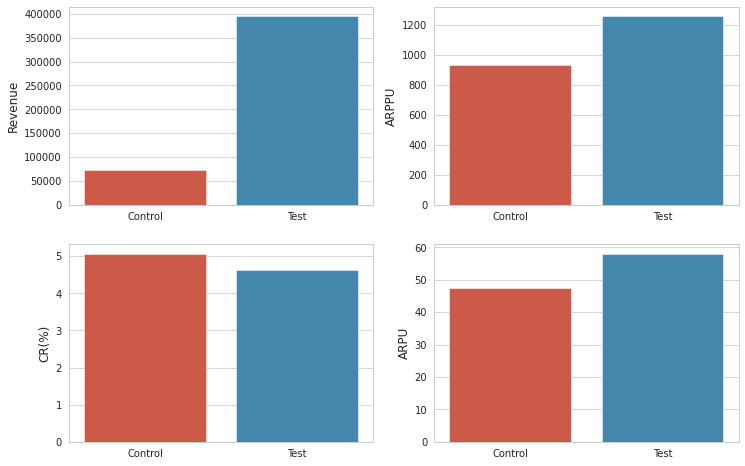

In [48]:
visualize_metrics()